<a href="https://en.wikipedia.org/wiki/Curonians" target="_blank"><img src="http://www.juratealbertas.lt/padidinti/Resources/pilkope8.jpg" alt="IMAGE ALT TEXT HERE" width="480" border="10"/></a>

--------------------
curonia is a Jupyter notebook that provides some example code to produce [animations](https://www.youtube.com/watch?v=j4Ut4krp8GQ) with baltic. Two things are required at a minimum to produce an animation:
- a phylogenetic tree calibrated in time with annotations on every branch
- a set of coordinates that will be the foci of migrations occurring on the tree
- (can be optional with adjustments) geoJSON polygons to represent geographic areas
- (optional) other time-varying values to be represented as geographic area colour and/or plotted alongside the map and the tree

Tree annotations, geoJSON polygons and point coordinates need to be standardised so that a branch on the phylogenetic tree going from location A to location B can call up the correct origin and destination points A and B on the map.

------------

Copyright 2017 [Gytis Dudas](https://twitter.com/evogytis). Licensed under a [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-nc-sa/4.0/).


## Importing libraries
---------
You will need several libraries to run this notebook:
- [baltic](https://github.com/blab/baltic) for tree parsing
- matplotlib for plotting
- bezier for plotting Bezier curves
- scipy for interpolation of tertiary data and smoothing data curves
- sklearn for performing PCA

In [1]:
import imp
bt = imp.load_source('baltic','/Users/evogytis/Documents/BLAB_baltic/baltic.py') ## point to where baltic repo was cloned

In [2]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon ## for polygons
from matplotlib.collections import PatchCollection ## for polygons too
from matplotlib.colors import LinearSegmentedColormap ## for colour maps
from matplotlib import gridspec ## for composite figures
import matplotlib.patheffects as path_effects ## for elegant text
from IPython.display import clear_output
from IPython.display import HTML

import datetime
import math
import time
import sys
import unicodedata
# import unidecode ## for removing diacritics from example geoJSON

import numpy as np
from scipy.interpolate import UnivariateSpline ## used to smooth counts of lineages in each location at any given time
from scipy.interpolate import interp1d ## used to linearly interpolate between data points used in colouring polygons
from sklearn.decomposition import IncrementalPCA ## used to identify PCA1 when automatically producing a colour map

import bezier ## custom arbitrary order Bezier curves
import requests ## used to fetch examples from internet
import json ## used for importing JSONs
from StringIO import StringIO ## used to import internet examples

def removeDiacritics(string):
    """
    Removes diacritic marks from unicode.
    """
    output=None
    if isinstance(string, str):
        output=string
    elif isinstance(string, unicode):
#         output=string.encode('utf-8')
#         output=unidecode.unidecode(string)
#         nkfd_form = unicodedata.normalize('NFKD', unicode(string))
#         output= u"".join([c for c in nkfd_form if not unicodedata.combining(c)])
#         output = ''.join((c for c in unicodedata.normalize('NFD', string) if unicodedata.category(c) != 'Mn'))
        output=unicodedata.normalize('NFKD', string).encode('ASCII', 'ignore')
    return output

def calendarTimeline(start_date, end_date, infmt='%Y-%m-%d',outfmt='%Y-%b',optfmt=None,month_step=1):
    """
    Given two calendar dates returns a list of calendar dates at monthly (by default) intervals.
    """
    current_date = datetime.datetime.strptime(start_date,infmt)
    ending_date = datetime.datetime.strptime(end_date,infmt)
    
    timeline=[]
    while current_date <= ending_date:
        if optfmt and current_date.month!=1:
            d=datetime.datetime.strftime(current_date,optfmt)
        else:
            d=datetime.datetime.strftime(current_date,outfmt)
        timeline.append(d)
        carry, new_month = divmod(current_date.month - 1 + month_step, 12)
        new_month += 1
        current_date = current_date.replace(year=current_date.year + carry,month=new_month)
    return timeline

typeface='Helvetica Neue' ## set default matplotlib font and font size
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22

frame='<iframe style="border: 0; width: 400px; height: 472px;" src="https://bandcamp.com/EmbeddedPlayer/album=29809561/size=large/bgcol=333333/linkcol=e99708/artwork=small/transparent=true/" seamless><a href="http://romowerikoito.bandcamp.com/album/nawam-r">NAWAMAR by Romowe Rikoito</a></iframe>'

print 'Done!'
HTML(frame)

Done!


### Importing geoJSON

-----------

In this part we import the polygons used as a back drop for the animation. The example used here is based on a map of South American countries from [SpreaD3](https://rega.kuleuven.be/cev/ecv/software/SpreaD3). First we'll import the geoJSON and save a local copy (for those long flights).

In [3]:
address='https://raw.githubusercontent.com/phylogeography/SpreaD3/master/data/geoJSON_maps/subregion/subregion_South_America_subunits.json' ## address of example JSON

try: ## if there's internet
    fetch_map = requests.get(address) ## fetch Central America geoJSON file from SpreaD3 repo as an example
    json_map=json.load(StringIO(fetch_map.text)) ## import json
    json.dump(json_map,open('./baltic_example.geojson','w')) ## write to file locally
except: ## no internet
    json_map=json.load(open('./baltic_example.geojson','r')) ## read from (hopefully saved) local copy

print 'Done!'

Done!


## Converting geoJSON into polygons
---------

We then process the geoJSON. We identify the field name that holds location names. In the example geoJSON it is `name`. We iterate over the features (countries) of the geoJSON and add their polygon coordinates to a list (`location_points`), we then convert each set of coordinates (if there are multiple polygons, _e.g._ islands) present in a feature into `matplotlib` closed polygons. If you start with a well-formatted geoJSON you should need minimal modification of the code here to produce your own animation. Parts of the code should also work with other formats, like shapefiles, if you import those using other libraries.

At the end you must have a dictionary called `polygons` where each feature in a geoJSON maps to a list of matplotlib polygon objects.

In [4]:
features=json_map['features']
location_points={} ## location points will be stored here
polygons={} ## polygons will be stored here

locName='name' ## key name for each feature

for loc in features: ## iterate through features (locations)
    poly = np.asarray(loc['geometry']['coordinates']) ## get coordinates
    location=removeDiacritics(loc['properties'][locName]) ## standardised location name (remove diacritics)
    
    if location not in ['Isla Sala y Gomez']: ## ignore Isla Sala y Gomez
        polygons[location]=[]
        location_points[location]=[]
        if loc['geometry']['type']=='MultiPolygon': ## multiple parts detected
            for part in np.asarray(poly): ## iterate over each component polygon
                for coords in np.asarray(part): ## iterate over coordinates
                    coords=np.array(coords)
                    xs=coords[:,0] ## longitudes
                    ys=coords[:,1] ## latitudes

                    location_points[location].append(np.vstack(zip(xs,ys))) ## append coordinates to location's list of coordinates
        if loc['geometry']['type']=='Polygon': ## location is single part
            for coords in np.asarray(poly): ## iterate over coordinates
                coords=np.array(coords)
                xs=coords[:,0] ## longitudes
                ys=coords[:,1] ## latitudes

                location_points[location].append(np.vstack(zip(xs,ys))) ## append coordinates to location's list of coordinates

        complete_location=[]
        for part in location_points[location]: ## iterate over each component of a location
            complete_location.append(Polygon(part,True)) ## create a polygon for each component of a location

        polygons[location]=complete_location ## assign list of polygons to a location
    elif location=='Isla Sala y Gomez': ## if location is Isla Sala y Gomez - print a geoJSON entry example
        print 'example geoJSON entry:\n%s\n\nnote that only the coordinate field is called\n'%(loc)
        
print 'polygons loaded:\n%s'%(polygons.keys())

example geoJSON entry:
{u'geometry': {u'type': u'MultiPolygon', u'coordinates': [[[[-80.715321, -33.772882], [-80.732086, -33.775323], [-80.748891, -33.773533], [-80.759348, -33.766778], [-80.777333, -33.73447], [-80.767079, -33.701104], [-80.740834, -33.685154], [-80.710927, -33.705336], [-80.707265, -33.716241], [-80.703603, -33.73447], [-80.702056, -33.753595], [-80.704701, -33.766778], [-80.715321, -33.772882]]], [[[-78.815785, -33.608819], [-78.806752, -33.609633], [-78.788971, -33.609063], [-78.780385, -33.613458], [-78.757639, -33.643243], [-78.769276, -33.642348], [-78.780181, -33.642999], [-78.790517, -33.645603], [-78.799875, -33.650649], [-78.808502, -33.644301], [-78.812856, -33.650649], [-78.841054, -33.636326], [-78.863637, -33.630466], [-78.884999, -33.632745], [-78.92101, -33.647882], [-78.944692, -33.652927], [-78.956899, -33.656915], [-78.979482, -33.669122], [-78.987375, -33.668552], [-78.991689, -33.656915], [-78.96703, -33.633396], [-78.943227, -33.616469], [-78.93

## Importing migration centre coordinates
----------
At a bare minimum the animation requires coordinates for migration centres. These are the points between migrations are animated. The following example fetches a spreadsheet that links countries to their capitals and capitals' coordinates. Since this is all automated, not all polygons loaded in the previous cells are autonomous countries and thus do not have capitals. For those few we just take the mean of their polygon coordinates. These coordinates (a tuple of longitude and latitude) are assigned to each location in the `popCentres` dictionary. Animated lineages migrate between coordinates identified in the `popCentres` dictionary.

In this example we also aggregate individual locations into higher order structures. This is meant to make the entire framework flexible when dealing with subnational divisions that should share a colour map and aggregating tertiary data used to colour polygons into numbers that can be shown on a graph for the higher order agglomeration. `aggregation` is a dictionary that maps each location in `popCentres` to a higher order group. Note that if you have no need of this functionality just ensure that `aggregation` maps each location's name to itself.

At the end you must have a `popCentres` dictionary that can return a longitude and latitude for each location, and an `aggregation` dictionary that groups locations into some higher-order (or back to individual locations if not needed).

In [5]:
try: ## if internet available - fetch a list of country capitals and their coordinates
    fetch_popCentres = requests.get('http://techslides.com/demos/country-capitals.csv') ## fetch a list of country capitals and their coordinates
    outPop=open('./country-capitals.csv','w') ## create local file
    outPop.write(fetch_popCentres.content) ## dump fetched file
    outPop.close() ## save local file
    popFile=StringIO(fetch_popCentres.text) ## stream from fetched copy
except: ## no internet
    popFile=open('./country-capitals.csv','r') ## fetch from (hopefully saved) local copy

popCentres={} ## dictionary with point coordinates
#locations=[]

for line in popFile: ## iterate over spreadsheet of coordinates
    l=line.strip('\n').split(',')
    if l[0] in polygons.keys(): ## if country matches a location for which polygon is available
        country,capital,lat,lon,iso,region=l ## extract information from row
        popCentres[country]=(float(lon),float(lat)) ## assign longitude and latitude to location
        #locations.append(country)

for loc in polygons.keys(): ## iterate through locations
    if popCentres.has_key(loc)==False: ## if capital coordinates were not found during the previous pass
        popCentres[loc]=np.mean([np.mean(poly.get_verts(),axis=0) for poly in polygons[loc]],axis=0) ## assign pop centroid as mean of all polygon coordinates
        #locations.append(loc)
        
print 'migration centres:\n%s\n'%(popCentres.keys())
print 'dictionary format for migration centre coordinates:\n%s\n'%(popCentres)

# aggregation={centre:centre for centre in popCentres.keys()} ## no higher-order aggregation (each location maps to itself)
aggregation={'Brazil':'group A', 'Suriname':'group A', 'Guyana':'group A', 'French Guiana':'group A', 'Colombia':'group B', 'Venezuela':'group B', 'Ecuador':'group B', 'Peru':'group C', 'Chile':'group C', 'Bolivia':'group C', 'Uruguay':'group D', 'Paraguay':'group D', 'Argentina':'group D','Falkland Is.':'group E','Galpagos Is.':'group F'} ## aggregate individual locations into higher-order groups (e.g. subdivisions into a country)

assert len(aggregation.keys())>=len(popCentres.keys()),'Not all popCentres locations were assigned to a higher order group in aggregation dictionary'

members={group:[loc for loc in aggregation.keys() if aggregation[loc]==group] for group in set(aggregation.values())}

print 'dictionary format for aggregation of locations:\n%s'%(aggregation)

migration centres:
[u'Brazil', u'Chile', u'Suriname', u'Uruguay', 'Galpagos Is.', u'Peru', 'French Guiana', u'Colombia', u'Guyana', u'Paraguay', u'Argentina', u'Bolivia', u'Venezuela', 'Falkland Is.', u'Ecuador']

dictionary format for migration centre coordinates:
{u'Brazil': (-47.916667, -15.783333333333333), u'Chile': (-70.666667, -33.45), u'Suriname': (-55.166667, 5.833333333333333), u'Uruguay': (-56.166667, -34.85), 'Galpagos Is.': array([-9.08529625e+01,  1.38909087e-02]), u'Peru': (-77.05, -12.05), 'French Guiana': array([-53.32454797,   3.7476259 ]), u'Colombia': (-74.083333, 4.6), u'Guyana': (-58.15, 6.8), u'Paraguay': (-57.666667, -25.266666666666666), u'Argentina': (-58.666667, -34.583333333333336), u'Bolivia': (-68.15, -16.5), u'Venezuela': (-66.866667, 10.483333333333333), 'Falkland Is.': array([-60.08539903, -51.67778839]), u'Ecuador': (-78.5, -0.21666666666666667)}

dictionary format for aggregation of locations:
{'Brazil': 'group A', 'Colombia': 'group B', 'French Guian

## Importing tertiary data
-----------
In case we have additional data not tied to the tree, like case numbers, we can show them on the map as changes in polygon colour. For this we convert data in `loc_data` dictionary, which maps locations to a dictionary that maps calendar dates to a particular value _e.g._ 

`loc_data = {
        'location A':{
                      '2017-01-01':100,
                      '2017-01-08':200
                      },
        'location B':{
                      '2018-01-01':5
                      }
}`

We then convert this dictionary into `polygon_data` dictionary, which in this example is an interpolation function able to return a linearly interpolated value for each location at any arbitrary time point. At the end `polygon_data` must contain some function that can return a number given a time point for each location.

We also get the `polygon_max` dictionary, that identifies the maximum value ever observed for each higher order group of locations. This is used later on to make sure that colour maps are consistent for each higher order group.


In [6]:
minValue,maxValue=0,1000 ## minimum and maximum observed values
minObs,maxObs=2,20 ## minimum and maximum observations per location

# loc_data={loc:{} for loc in popCentres.keys()} ## no tertiary data
loc_data={loc:{'%d-%02d-%02d'%(np.random.randint(2016,2019),np.random.randint(1,12),np.random.randint(1,28)):np.random.randint(minValue,maxValue) for t in range(np.random.randint(minObs,maxObs))} for loc in popCentres.keys()} ## create random tertiary data for each polygon

print 'polygon data input dictionary:\n%s\n'%(loc_data)

data_timelines={} ## will contain a sorted list of time points for which data are available in a location
polygon_data={} ## will contain tertiary data available for each location, in their temporal order

for loc in loc_data.keys():
    data_timelines[loc]=sorted(loc_data[loc].keys(),key=lambda w:bt.decimalDate(w)) ## for each location remember the sorted timeline for which data are available
    
    if len(data_timelines[loc])>1: ## if there are entries
        polygon_data[loc]=interp1d(map(bt.decimalDate,data_timelines[loc]),[loc_data[loc][day] for day in data_timelines[loc]],bounds_error=False) ## for each location generate an interpolation function that will be able to return a number given a time point
    else: ## not enough entries for interpolation - function will return 0.0 whenever called
        polygon_data[loc]=lambda d:0.0

polygon_max={} ## will contain the maximum value observed in a given high order group at any point
for group in set(aggregation.values()): ## iterate over higher order group designation
    if max([len(loc_data[loc].values()) for loc in members[group]])>0: ## if group has sufficient data
        polygon_max[group]=float(max([max(loc_data[loc].values()) for loc in members[group]])) ## for each higher-order group identify the maximum existing value (used to produce numbers in range [0,1] for colour maps later on)
    else:
        polygon_max[group]=1.0 ## insufficient data - maximum is set to 1.0

print 'maximum polygon data values:\n%s\n'%(polygon_max)

polygon data input dictionary:
{u'Brazil': {'2018-05-14': 322, '2018-10-06': 370, '2017-04-05': 892, '2017-04-11': 189, '2018-02-20': 635, '2016-08-19': 559, '2018-07-02': 926, '2017-01-14': 205, '2018-03-10': 940, '2018-10-12': 821, '2017-11-25': 925, '2017-02-19': 574, '2017-09-02': 725}, u'Suriname': {'2017-03-21': 469, '2016-05-08': 81, '2018-07-10': 618, '2017-08-03': 912, '2018-11-06': 944, '2016-11-24': 231, '2018-11-16': 109, '2017-08-25': 379, '2017-10-09': 139, '2016-10-19': 891, '2018-01-04': 123, '2016-05-20': 303, '2018-08-04': 757, '2017-07-24': 140, '2017-02-24': 687, '2016-10-05': 277, '2018-08-19': 207, '2018-08-03': 954, '2018-04-24': 947}, u'Uruguay': {'2018-03-11': 820, '2017-03-27': 221, '2018-11-06': 391, '2018-01-05': 647, '2017-08-10': 939, '2017-02-13': 924, '2017-07-16': 41, '2016-09-25': 38}, 'Galpagos Is.': {'2017-08-18': 623, '2018-03-18': 620}, 'Falkland Is.': {'2017-10-21': 745, '2018-04-03': 148, '2018-01-12': 455, '2018-05-11': 258, '2017-09-26': 119, '

## Importing a labeled phylogeny
-------
A phylogenetic tree with labeled states is necesarry to animate migration. Migrations are animated whenever a branch is in a trait state that is not the same as its parent node. Phylogenies can be imported from nexus files or nexstrain.org's JSON format. In this example we load an H3N2 HA phylogeny sampled over a period of 3 years from nextstrain.org, and assign each branch in the tree to a random location. If your geoJSON, `popCentres` and tree do not have location names standardised across them you can use a dictionary to rename your trait states in the phylogeny so they match those in `popCentres`. 

At the end you should have a baltic tree under variable `bt_tree`, calibrated in absolute time with `locTrait` variable set to whatever the name of your trait of interest is.

In [7]:
address='http://data.nextstrain.org/flu_seasonal_h3n2_ha_2y_tree.json'

try: ## if there's internet - fetch an example tree from nextstrain.org
    fetch_tree = requests.get(address) ## fetch tree
    outTree=open('./baltic_example.json','w') ## create empty local file
    outTree.write(fetch_tree.content) ## dump tree to local file
    outTree.close() ## save local file
    treeFile=StringIO(fetch_tree.text) ## stream from repo copy
except: ## no internet
    treeFile=open('./baltic_example.json','r') ## stream from (hopefully saved) local copy

translation={'name':'strain','absoluteTime':'num_date'} ## define translations between JSON and baltic
bt_tree=bt.loadJSON('./baltic_example.json',translation) ## import tree from JSON

locTrait='region' ## trait name for location in tree

tree_locs=list(set([k.traits[locTrait] for k in bt_tree.Objects])) ## fetch all trait states in tree

np.random.shuffle(tree_locs) ## randomise order of trait states from the tree
pretend={t:m for t,m in zip(tree_locs,popCentres.keys())} ## assign each tree state to a polygon name

for k in bt_tree.Objects: ## iterate over every branch in tree
    k.traits[locTrait]=pretend[k.traits[locTrait]] ## recode tree trait states into those from the map

tree_locs=set([k.traits[locTrait] for k in bt_tree.Objects]) ## get current set of trait states in tree
print '%d tree locations: %s'%(len(tree_locs),', '.join(tree_locs))
print '%d map locations (defined migration centres): %s'%(len(popCentres.keys()),', '.join(popCentres.keys()))
assert tree_locs.issubset(set(popCentres.keys())),'Coordinates for state(s) %s present in the tree not provided'%(', '.join(tree_locs.difference(set(popCentres.keys())))) ## every state present in the tree has to correspond to a set of coordinates


Tree height: 7.181608
Tree length: 619.550485
annotations present

Numbers of objects in tree: 4086 (1849 nodes and 2237 leaves)

10 tree locations: Brazil, Suriname, Uruguay, Galpagos Is., Chile, French Guiana, Peru, Guyana, Paraguay, Colombia
15 map locations (defined migration centres): Brazil, Chile, Suriname, Uruguay, Galpagos Is., Peru, French Guiana, Colombia, Guyana, Paraguay, Argentina, Bolivia, Venezuela, Falkland Is., Ecuador


## Finding borders of interest
---------
For aesthetic reasons we might want to highlight particular borders. The following code iterates over pairs of polygons and finds points shared by polygons that are in different categories, as defined by `aggregation`. Depending on the level of detail, number of polygons, _etc_. this operation might take a while and thus you might want to run this once and save the results to be imported later. If geoJSON polygons were not created by the same author, or the polygons come from datasets with different resolutions it is very easy to end up with polygons that don't share any points and thus no border can be found.

Each individual stretch of the border is stored in a list of border coordinate stretches called `international_border`.

In [8]:
border_sharing={locA:{locB:False for locB in polygons} for locA in polygons}

international_border=[]

for i,locA in enumerate(polygons): ## iterate over polygons
    for j,locB in enumerate(polygons): ## iterate over polygons again
        if i>j and aggregation[locA]!=aggregation[locB]: ## only do one pairwise comparison
            print i,j,locA,locB
            for partA in polygons[locA]: ## iterate over constituent polygons of location A
                setA=set(map(tuple,partA.get_verts())) ## convert coordinates of polygon into a set of tuples
                
                for partB in polygons[locB]:  ## iterate over constituent polygons of location B
                    setB=set(map(tuple,partB.get_verts())) ## convert coordinates of polygon into a set of tuples
                    temp=[] ## temporary storage
                    if setA.isdisjoint(setB)==False: ## if polygon A and polygon B share coordinates
                        
                        for point in map(tuple,partA.get_verts()): ## for each point in polygon A
                            if point in setA.intersection(setB) and point not in temp: ## if it is also present in polygon B and not seen yet - add to temporary list
                                temp.append(point)
                                
                    if len(temp)>0: ## if overlap between polygon A and B is not zero
                        international_border.append(temp) ## add to list of international border coordinates

1 0 Chile Brazil
2 1 Suriname Chile
3 0 Uruguay Brazil
3 1 Uruguay Chile
3 2 Uruguay Suriname
4 0 Galpagos Is. Brazil
4 1 Galpagos Is. Chile
4 2 Galpagos Is. Suriname
4 3 Galpagos Is. Uruguay
5 0 Peru Brazil
5 2 Peru Suriname
5 3 Peru Uruguay
5 4 Peru Galpagos Is.
6 1 French Guiana Chile
6 3 French Guiana Uruguay
6 4 French Guiana Galpagos Is.
6 5 French Guiana Peru
7 0 Colombia Brazil
7 1 Colombia Chile
7 2 Colombia Suriname
7 3 Colombia Uruguay
7 4 Colombia Galpagos Is.
7 5 Colombia Peru
7 6 Colombia French Guiana
8 1 Guyana Chile
8 3 Guyana Uruguay
8 4 Guyana Galpagos Is.
8 5 Guyana Peru
8 7 Guyana Colombia
9 0 Paraguay Brazil
9 1 Paraguay Chile
9 2 Paraguay Suriname
9 4 Paraguay Galpagos Is.
9 5 Paraguay Peru
9 6 Paraguay French Guiana
9 7 Paraguay Colombia
9 8 Paraguay Guyana
10 0 Argentina Brazil
10 1 Argentina Chile
10 2 Argentina Suriname
10 4 Argentina Galpagos Is.
10 5 Argentina Peru
10 6 Argentina French Guiana
10 7 Argentina Colombia
10 8 Argentina Guyana
11 0 Bolivia Brazi

## Fixing border coordinates
--------
Sometimes the coordinates of a polygon begin in the middle of their border, resulting in plotting artefacts. This bit of the code shifts the coordinates such that the largest distance between adjacent coordinates occurs between the beginning and end of the border stretch.

In [9]:
distance=lambda p:abs(p[0][0]-p[1][0])+abs(p[0][1]-p[1][1]) ## function to get Euclidean distance

for s,stretch in enumerate(international_border): ## iterate over every segment of international border
    distances=[distance((stretch[i],stretch[i-1])) for i in range(len(stretch))] ## get distances between consecutive points
    M=max(distances) ## get largest distance
    idx=distances.index(M) ## identify where the largest distance is
    if idx!=0: ## if the largest distance is not between the first and last point of the border stretch... 
        international_border[s]=international_border[s][idx:]+international_border[s][:idx] ## reorganise the stretch such that the largest distance occurs between first and last points of the stretch

## Defining colour maps
------
For every location belonging to a group we use PCA on their coordinates defined in `popCentres` dictionary to identify the axis of greatest variation. This axis is used to assign a value between 0 and 1 to each location that's related to the location's index along the axis of most variation. These values are later used to pick out colour values for each location and are stored in a dictionary called `normalised_coordinates`.

Each high order group also gets a colour map. These are based on drawing a base colour for each group from colour map `cmap` and creating a single-colour colour map by altering luminosity and saturation (low-saturation high-luminosity for low values to high-saturation low-luminosity for high values). Base colours for each group are drawn on the basis of PCA1 performed on mean coordinate of location migration centres defined in `popCentres`.

At the end of this you should have a dictionary called `group_colours` that maps high-order group names to a function that given a number between 0 and 1 will return a colour. You also need `normalised_coordinates` that assigns a number between 0 and 1 to each location which is later used to give each location a unique colour from its group's colour map.

group F 1 [-90.85296245001426]
group D 3 [-56.166667, -57.666667, -58.666667]
group E 1 [-60.085399028348654]
group B 3 [-74.083333, -66.866667, -78.5]
group C 3 [-70.666667, -77.05, -68.15]
group A 4 [-47.916667, -55.166667, -53.3245479712526, -58.15]


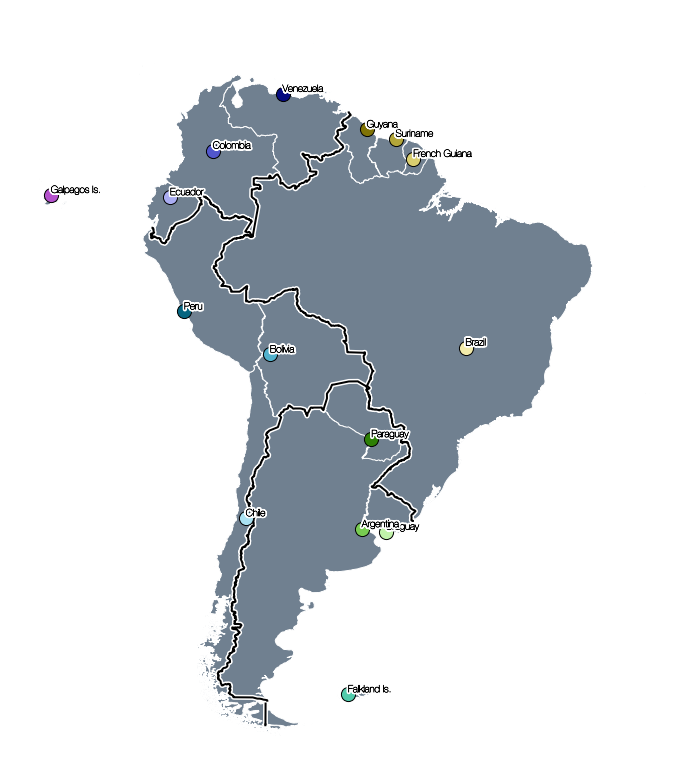

['group F', 'group B', 'group C', 'group E', 'group D', 'group A']


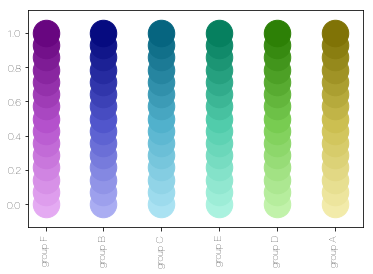

In [10]:
def desaturate(rgb,sat,lum):
    if isinstance(rgb,unicode) or isinstance(rgb,str):
        rgb=mpl.colors.hex2color(rgb) ## convert to rgb if string given
    elif np.array(rgb).shape[-1]==4: ## if there's four values
        rgb=rgb[:-1]

    assert 0.0<=sat<=1.0,'Desaturation outside allowed interval'
    assert np.array(rgb).shape[-1]==3,'Incorrect colour array shape'
    hsv=mpl.colors.rgb_to_hsv(rgb) ## convert rgb vector to hue, saturation, value
    hsv[1]=sat ## use provided saturation
    hsv[2]=lum ## use provided luminosity
    
    return mpl.colors.hsv_to_rgb(hsv) ## convert back to rgb

group_coordinates={}
normalised_coordinates={}
for high_order in set(aggregation.values()): ## iterate over high order group
    locs=[loc for loc in popCentres.keys() if aggregation[loc]==high_order] ## get locations in group
    sorted_locations=sorted(locs,key=lambda loc:popCentres[loc][0]) ## sort locations in group
    group_coordinates[high_order]=np.mean([popCentres[loc] for loc in sorted_locations],axis=0)
    print high_order,len(locs),[popCentres[loc][0] for loc in locs]
    
    if len(locs)>2: ## for more than two locations colour coordinates based on their index along PCA1
        loc_pca = IncrementalPCA(n_components=2) ## create PCA object
        loc_pca.fit([popCentres[loc] for loc in locs]) ## fit population centroid coordinates
        loc_transformed=map(tuple,loc_pca.transform([popCentres[loc] for loc in locs])) ## get PCA coordinates for population centroids
        sorted_transform=sorted(map(tuple,loc_transformed),key=lambda x:x[0]) ## sort coordinates by x
        
        for l,loc in enumerate(locs):
            normalised_coordinates[loc]=sorted_transform.index(loc_transformed[l])/float(len(locs)-1)
    else:
        for l,loc in enumerate(locs):
            normalised_coordinates[loc]=(0.5+float(l))/float(len(locs))
        
sorted_group=sorted(list(set(aggregation.values())),key=lambda x:group_coordinates[x][0]) ## sort high-order groups according to longitude

ipca = IncrementalPCA(n_components=2) ## create PCA object
ipca.fit([group_coordinates[g] for g in sorted_group]) ## fit population centroid coordinates
transformed=ipca.transform([group_coordinates[g] for g in sorted_group]) ## get PCA coordinates for population centroids

XS=transformed[:,0] ## get PCA component 1

xnorm=mpl.colors.Normalize(0,len(XS)-1) ## create normalisation (index-based)

cmap=mpl.cm.viridis ## base colour map

group_colours={high_order:None for high_order in sorted_group}
for group,pos in zip(sorted_group,np.linspace(0.0,1.0,len(sorted_group))): ## iterate over transformed coordinates
    clist=[]
    clist.append([0.0,desaturate(cmap(pos),0.3,0.95)]) ## 0.0 in cmap is 30% saturated, 95% bright
    clist.append([0.5,desaturate(cmap(pos),0.6,0.8)]) ## 0.5 is 60% saturated, 80% bright
    clist.append([1.0,desaturate(cmap(pos),0.95,0.5)]) ## 1.0 is 95% saturated, 50% bright
    group_colours[group]=mpl.colors.LinearSegmentedColormap.from_list(group,clist) ## create colour map

fig,ax = plt.subplots(figsize=(15,14),facecolor='w') ## start figure

for loc in popCentres.keys():
    x,y=popCentres[loc]
    group=aggregation[loc]
    cmap=group_colours[group]
    c=cmap(normalised_coordinates[loc])
    
    ax.scatter(x,y,s=200,facecolor=c,edgecolor='k',zorder=20) ## plot population centre

    effects=[path_effects.Stroke(linewidth=4, foreground='white'),
                 path_effects.Stroke(linewidth=0.5, foreground='k')] ## black text, white outline

    ax.text(x,y,loc,va='bottom',ha='left',zorder=100,path_effects=effects) ## add its name
    
    
for i,loc in enumerate(polygons.keys()): ## iterate over locations
    ax.add_collection(PatchCollection(polygons[loc],facecolor='slategrey',edgecolor='w',lw=1,zorder=1)) ## add polygon

for stretch in international_border: ## plot borders
    xs,ys=zip(*stretch)
    ax.plot(xs,ys,color='k',zorder=11,lw=2)
    ax.plot(xs,ys,color='w',zorder=10,lw=5)

[ax.spines[loc].set_visible(False) for loc in ax.spines]
ax.tick_params(size=0)
ax.set_xticklabels([])
ax.set_yticklabels([])
    
ax.set_aspect(1)
plt.show()

fig,ax = plt.subplots(figsize=(len(sorted_group),4),facecolor='w') ## start figure
print sorted_group
for g,group in enumerate(sorted_group):
    for i in np.linspace(0.0,1.0,15):
        ax.scatter(g,i,s=700,color=group_colours[group](i),zorder=20) ## plot a column of points with colours of the colour map

ax.set_xticks(range(len(sorted_group)))
ax.set_xticklabels(sorted_group,rotation=90)

plt.show()

## Defining circles at migration centres
----------
Here we define functions for each location that return the radius of a circle sitting on top of the migration centre at any given time point. Here circle radii are proportional to the number of lineages at a given location, with some smoothing.

At the end dictionary `circle_function` should map each location to a function that returns a number used to define the radius of a circle, given an arbitrary time point.

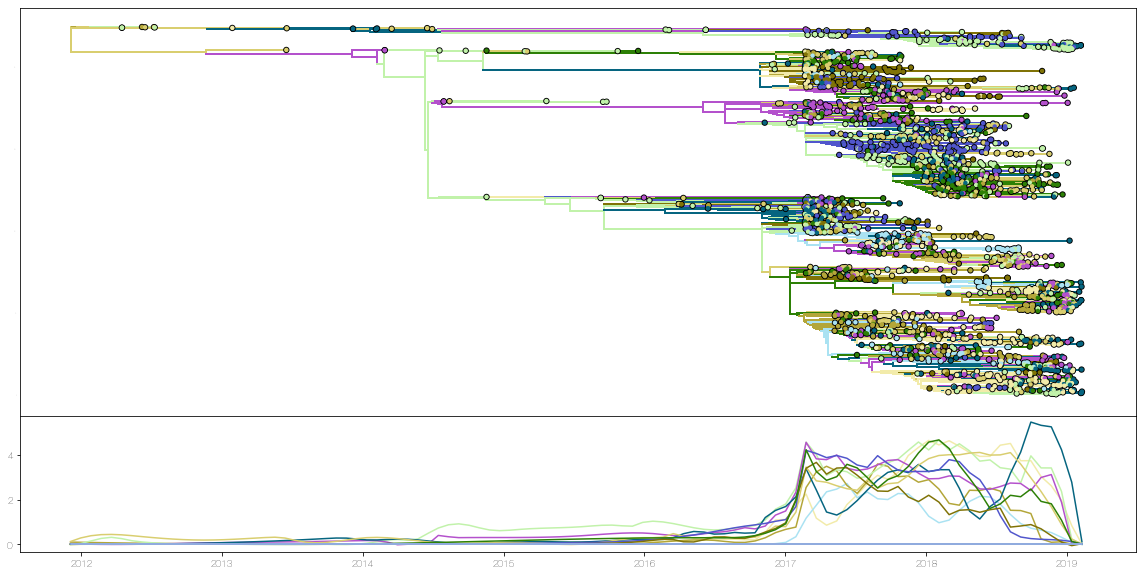

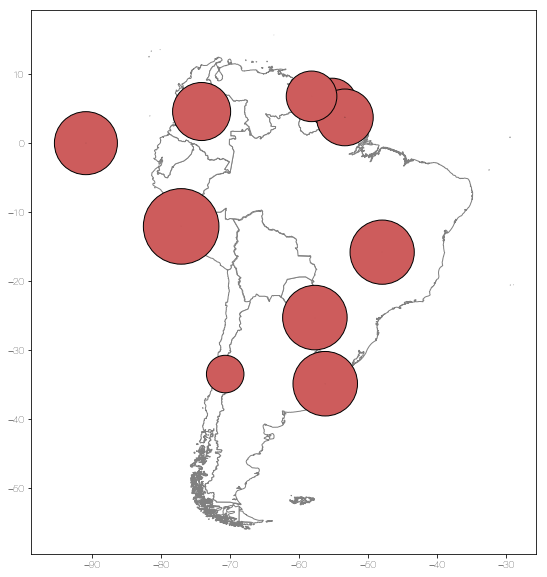

In [11]:
tipSize=20
branchWidth=2

plt.figure(figsize=(20,10),facecolor='w') ## start figure
gs = gridspec.GridSpec(2, 1,height_ratios=[3,1],wspace=0.0,hspace=0.0) ## two row figure
ax1 = plt.subplot(gs[0]) ## ax1 is tree
ax2 = plt.subplot(gs[1],sharex=ax1) ## ax2 is a function for lineage presence circle radius

for k in bt_tree.Objects: ## iterate over branches in tree
    loc=k.traits[locTrait] ## get branch location
    group=aggregation[loc] ## get location's group
    cmap=group_colours[group] ## get group's colour map
    c=cmap(normalised_coordinates[loc]) ## get colour for location based on index of location along PCA1
    
    y=k.y ## y coordinate of branch
    yp=k.parent.y
    
    x=k.absoluteTime ## x coordinate of branch
    xp=k.parent.absoluteTime ## x coordinate of parent branch
    
    if k.branchType=='leaf': ## if leaf
        ax1.scatter(x,y,s=tipSize,facecolor=c,edgecolor='none',zorder=101) ## plot colour tip circle
        ax1.scatter(x,y,s=tipSize*2,facecolor='k',edgecolor='none',zorder=100) ## black outline underneath every tip
        
    elif k.branchType=='node': ## if node
        yl=k.children[0].y ## first child y coordinate
        yr=k.children[-1].y ## last child y coordinate
        
        if xp==0.0:
            xp=x

        ax1.plot([x,x],[yl,yr],color=c,lw=branchWidth,zorder=98) ## plot vertical bar
    ax1.plot([xp,x],[y,y],color=c,lw=branchWidth,zorder=98) ## plot branch
    
ax1.tick_params(size=0,labelsize=0) ## no ticks or tick labels on all axes

circle_function={loc:None for loc in popCentres.keys()}

root_date=bt_tree.root.absoluteTime ## date of tree root
last_tip=root_date+bt_tree.treeHeight ## last tip date in tree
x_grid=np.linspace(root_date,last_tip,100) ## 100 equally spaced points between root and last tip
    
for loc in popCentres.keys(): ## for each location
    group=aggregation[loc] ## get group
    cmap=group_colours[group] ## get colour map
    c=cmap(normalised_coordinates[loc]) ## get location's colour
    
    ys=[len([k for k in bt_tree.Objects if k.traits[locTrait]==loc and k.parent.absoluteTime<t<=k.absoluteTime]) for t in x_grid] ## calculate cumulative time spent in location
    ys=np.array(ys)/10.0 ## scale down
    spl=UnivariateSpline(x_grid,ys,s=0.1) ## use univariate spline...    
    
    circle_function[loc]=spl ## assign smoothed function to location
    ax2.plot(x_grid,circle_function[loc](x_grid),color=c) ## plot circle radii over time

plt.show()


plt.figure(figsize=(10,10),facecolor='w') ## start figure
gs = gridspec.GridSpec(1, 1,wspace=0.0,hspace=0.0)
ax3 = plt.subplot(gs[0]) ## ax3 is a map showing circle sizes at their maximum extent for each location

for loc in polygons.keys():
    ax3.add_collection(PatchCollection(polygons[loc],facecolor='w',edgecolor='grey')) ## plot polygons

for loc in popCentres.keys(): ## iterate over locations
    circle_radius=circle_function[loc] ## get circle radius function for location
    time_radii=[circle_radius(x) for x in x_grid if circle_radius(x)>0.0] ## calculate the radii for location over time, if they're not 0.0
    
    if len(time_radii)>0: ## if lineages are present
        radius_min,radius_max=min(time_radii),max(time_radii) ## get minimum and maximum radius values
    
        circle_min=plt.Circle(popCentres[loc],radius=radius_min,facecolor='steelblue',edgecolor='k',lw=1,zorder=101)
        circle_max=plt.Circle(popCentres[loc],radius=radius_max,facecolor='indianred',edgecolor='k',lw=1,zorder=100)
        ax3.add_patch(circle_min) ## plot circles at their minimum and maximum
        ax3.add_patch(circle_max)
ax3.plot() ## make sure polygons will be plotted
ax3.set_aspect(1) ## equal aspect

plt.show()

## Defining Bezier curves for migrating lineages
-------
This is where a significant portion of the magic happens. Bezier curves are smooth curved lines that are attracted by control points during their path from origin to destination like this:
![BezierGIF](https://upload.wikimedia.org/wikipedia/commons/1/15/Bezier_All_anim.gif)

Bezier curves have some nice properties:
- Bezier curves are parameterised by a floating point number between 0 and 1 (represented by _t_ in the GIF above). This means that we can recover the coordinates for the first half of a Bezier curve by calling the function with a handful of points in the interval [ 0.0 , 0.5 ].
- Any number of control points can be used, giving arbitrarily shaped curves to represent migrations.
- They are aesthetically pleasing.


We use the function `Bezier_control` defined in this cell to identify control points for Bezier curves going from point `A` to `B`, lying perpendicular to line `AB` at a distance `height`, fraction `frac` along the line `AB`. Using this function with Bezier curves is particularly suitable:

- Control points identified for line `AB` are mirrored compared to line `BA`. Means that as long as sufficient curvature is introduced into Bezier curves via control points, simulataneous migrations from A to B and B to A will not obscure each other.
- The `height` parameter in the function can be inversely proportional to distance between points. As a result two adjacent locations connected with high migration flux can still be visible as they curve substantially more than distant points.

At the end you should have a dictionary of dictionaries `migration_function` that given an origin and a destination location maps to a function that is able to convert a numpy array of values between 0.0 and 1.0 into a set of coordinates that define a path from origin to destination.

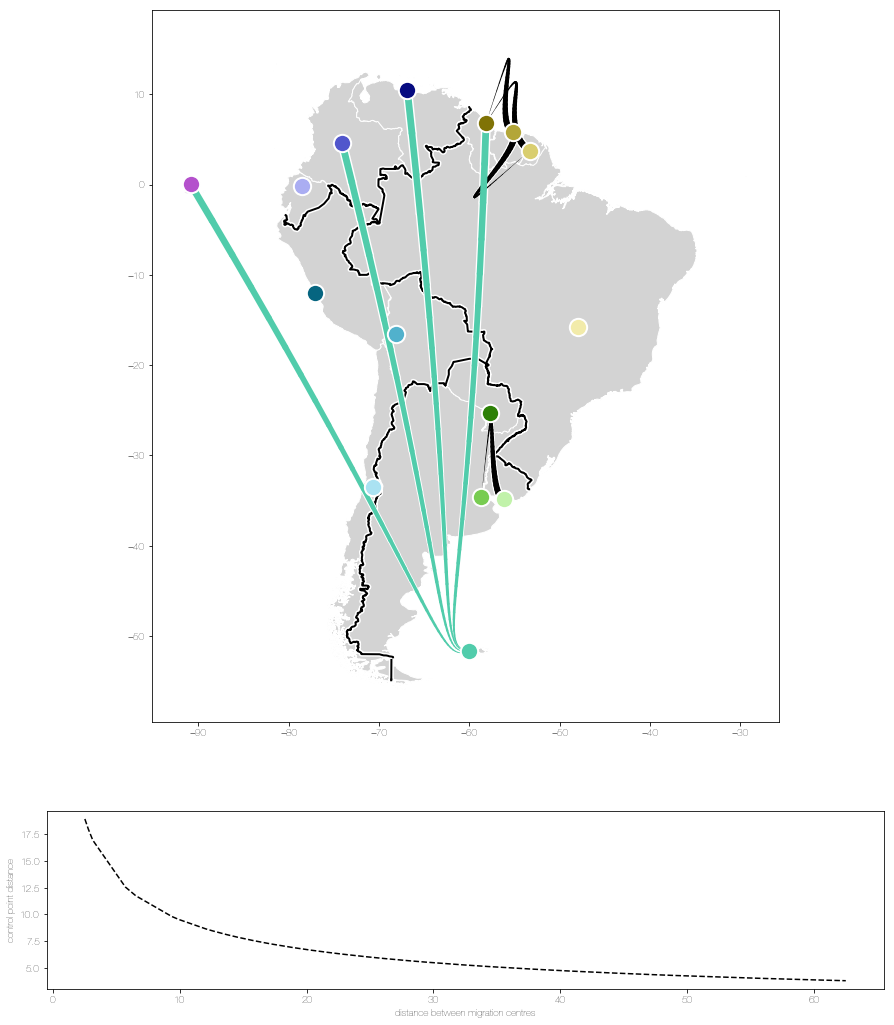

In [12]:
def Bezier_control(pointA,pointB,height,frac):
    """ 
    Given a line defined by 2 points A & B, 
    find a third point at a given distance (height) that defines a line perpendicular to line AB which intercepts AB at fraction (frac) along AB.
    Equation derived by Luiz Max Fagundes de Carvalho (University of Edinburgh).
    """
    x1,y1=pointA
    x2,y2=pointB

    sign=1
    if x1>x2:
        sign=-1

    slope = (y2-y1) / (x2-x1)
    d=np.sqrt((y2-y1)**2 + (x2-x1)**2) ## distance between points
    
    h=np.sqrt(height**2+(d*frac)**2) ## distance between desired height and point along line

    n1=x1+h*np.cos(np.arctan(height/float(d)/frac)+np.arctan(slope))*sign ## magic
    n2=y1+h*np.sin(np.arctan(height/float(d)/frac)+np.arctan(slope))*sign

    return (n1,n2) ## return third point's coordinate

plt.figure(figsize=(15,18),facecolor='w') ## start figure
gs = gridspec.GridSpec(2, 1,height_ratios=[4,1]) ## define subplots
ax1 = plt.subplot(gs[0]) ## map here
ax2 = plt.subplot(gs[1]) ## plot to show relationship between distances between migration centres and the distance of the control point to the straight line connecting migration centres

migration_function={i:{j:None for j in popCentres.keys() if i!=j} for i in popCentres.keys()} ## matrix of pairs of locations that will contain the Bezier function
all_distances=[] ## keep track of all distances
control=lambda d:30*(1/d)**0.5 ## function that will convert the distance between migration points into a distance to be used for finding the control point for a Bezier function

for i in popCentres.keys(): ## iterate over locations
    A=popCentres[i] ## fetch origin
    lon,lat=A
    groupA=aggregation[i] ## get origin's high order group
    c=group_colours[groupA](normalised_coordinates[i]) ## fetch colour map of the group, colour of location is determined by index of location's coordinates along PCA1
    ax1.scatter(lon,lat,s=300,facecolor=c,edgecolor='w',lw=2,zorder=100) ## plot migration centre
    
    for j in popCentres.keys(): ## iterate over locations again
        if i!=j: ## if not self
#             print 'first loop',i,j
            B=popCentres[j] ## fetch destination
            d=np.sqrt((B[1]-A[1])**2 + (B[0]-A[0])**2) ## calculate distance between location A and location B
            
            all_distances.append(d) ## remember actual distince
            
            bez_points=[A] ## Bezier curve will start at point A
#             bez_points.append(Bezier_control(A,B,1/d ,0.1))
#             bez_points.append(Bezier_control(A,B,0.01     ,0.2))
#             bez_points.append(Bezier_control(A,B,-0.02    ,0.3))
#             bez_points.append(Bezier_control(A,B,-d**0.5,0.4))
            bez_points.append(Bezier_control(A,B,control(d),0.01)) ## head towards the first control point, which is perpendicular to line AB at distance control(d), and 0.01 of the way along line AB
            bez_points.append(Bezier_control(A,B,0.0,0.1)) ## head towards second control point, directly on the line AB, 0.1 of the way along line AB
            bez_points.append(B) ## Bezier curve will finish at point B
            bez_points=np.array(bez_points).transpose()
            curve = bezier.Curve(np.asfortranarray(bez_points),degree=len(bez_points)) ## Bezier curve object
            migration_function[i][j]=curve.evaluate_multi ## only interested in calling the evaluate_multi function of the curve, which will return a list of coordinates, given a numpy array of fractions along the line

for loc in polygons.keys():
    ax1.add_collection(PatchCollection(polygons[loc],facecolor='lightgrey',edgecolor='w',zorder=1)) ## plot location polygons

for locA in popCentres.keys():
    for locB in popCentres.keys()[:popCentres.keys().index(locA)]: ## iterate over pairs of locations
        A=popCentres[locA]
        B=popCentres[locB]
        d=np.sqrt((B[1]-A[1])**2 + (B[0]-A[0])**2) ## calculate distance between locations A and B
        sD=sorted(all_distances)
        if locA!=locB and (d in sD[:7] or d in sD[-7:]): ## if locations aren't the same and are some of the longest  or shortest distances - plot away

            Bezier_smooth=35 ## number of coordinates at which to compute the Bezier curve (more = smoother curve)
            eval_Bezier=np.linspace(0.0,1.0,Bezier_smooth) ## numpy array of 35 values going from 0.0 to 1.0
            migration=migration_function[locA][locB](eval_Bezier) ## compute Bezier curve coordinates along the path
            xs,ys=migration ## unpack Bezier coordinates
            for q in range(len(xs)-1): ## iterate through Bezier line segments with fading alpha and reducing width
                x1,y1=xs[q],ys[q] ## coordinates of current point
                x2,y2=xs[q+1],ys[q+1] ## coordinates of next point
                
                segL=(q+1)/float(len(xs)) ## fraction along length of Bezier line
                if aggregation[locA]!=aggregation[locB]: ## locations in different high-order groups
                    fc=group_colours[aggregation[locA]](normalised_coordinates[locA]) ## colour by origin colour
                else: ## locations in same high-order group
                    fc='k' ## colour black
                    
                ax1.plot([x1,x2],[y1,y2],lw=7*segL,alpha=1,color=fc,zorder=99,solid_capstyle='round') ## plot actual lineage with width proportional to position along Bezier curve
                ax1.plot([x1,x2],[y1,y2],lw=10*segL,alpha=1,color='w',zorder=98,solid_capstyle='round') ## plot white outline underneath

for stretch in international_border: ## plot international border
    xs,ys=zip(*stretch)
    ax1.plot(xs,ys,color='k',zorder=11,lw=2)
    ax1.plot(xs,ys,color='w',zorder=10,lw=5)
    
ax1.set_aspect(1) ## equal aspect ratio

ax2.plot(sorted(all_distances),map(control,sorted(all_distances)),ls='--',color='k') ## plot distances between points against their control point distances
ax2.set_ylabel('control point distance')
ax2.set_xlabel('distance between migration centres')

plt.show()

## Defining animation parameters
---------
There's a few minor parameters which should be adapted for every new animation you might want to create. These are:

- `smooth` determines how many points of the Bezier curve to compute. Higher numbers give smoother curves, but also take longer to plot.
- `tracking_length` is a floating point number of days that determines how long a migrating lineage has to complete its migration. Larger number means lineages travel slower and stay on screen for longer. Default is 30 days.
- `departure_condition` is a function that returns a fraction for where the tail end of the migrating lineage is placed. Default is 0.5 behind the head of the migrating lineage, _i.e._ the tail of the migrating lineage emerges when the head is half the way towards its destination, and is at its peak when the head has reached its destination. If it were set to return 1.0 the tail would only emerge after the head has reached its destination.
- `transition_point` determines the fraction along the branch at which the migration happens. Default is set to 0.5.

If you want to make lineages migrate in proportion to how far along the branch the time line intersects it you would set `tracking_length` to branch length, `transition_point` to 1.0. This can result in misleading artefacts, such as long branches that represent unsampled lineages appearing to travel very slowly, whereas in reality they probably circulated around and travelled over a relatively short period of time.

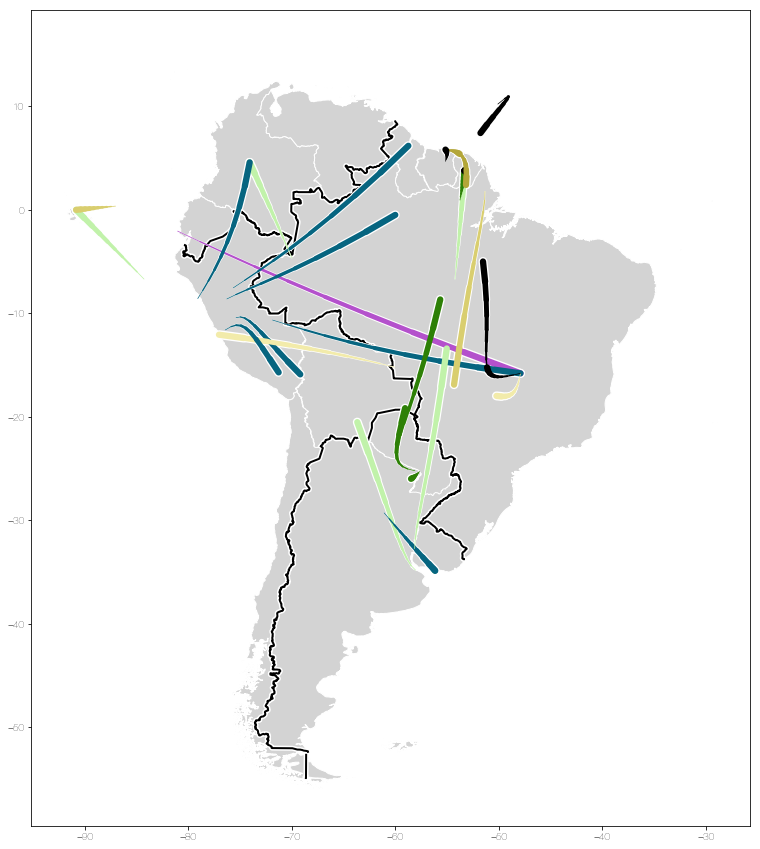

In [13]:
smooth=10 ## how many segments Bezier lines will have

tracking_length=30.0 ## number of days over which to plot the lineage
depth=tracking_length/365.0 ## convert to decimal years
departure_condition = lambda f:f-0.5 ## determines how far away (in Bezier fraction) the tail of the migrating lineage is
transition_point=0.5 ## determines the fixed time point along a branch at which migration happens

plt.figure(figsize=(15,15),facecolor='w') ## start figure
gs = gridspec.GridSpec(1, 1) ## define subplots
ax1 = plt.subplot(gs[0]) ## map here

for loc in polygons.keys():
    ax1.add_collection(PatchCollection(polygons[loc],facecolor='lightgrey',edgecolor='w',zorder=1)) ## plot location polygons

time_point=bt.decimalDate('2018-04-01') ## arbitrary time point at which to render the frame

for k in bt_tree.Objects: ## iterate over branches
    locA=''
    if k.parent.traits.has_key(locTrait):
        locA=k.parent.traits[locTrait] ## get location of parent
    locB=k.traits[locTrait] ## get location of branch
    
    if locA!='' and locA!=locB and k.parent.absoluteTime<time_point<=k.absoluteTime: ## if parent location is present, locations don't match, and branch is intersected
        transition=k.parent.absoluteTime+k.length*transition_point ## migration time
        
        begin_bezier=1-(transition-time_point)/float(depth) ## migrating lineage's head
        end_bezier=departure_condition(begin_bezier) ## migrating lineage's tail
        begin_bezier,end_bezier = np.clip([begin_bezier,end_bezier],0.0,1.0) ## restrict to interval [0,1]
        
        if end_bezier<=1.0 and begin_bezier>=0.0: ## if lineage should still be visible (head departed and tail hasn't arrived)
            points=np.linspace(end_bezier,begin_bezier,smooth) ## get a bunch of points between the start and end of migrating lineage
            bezier_line=migration_function[locA][locB](points) ## get coordinates of the migrating lineage
            xs,ys=bezier_line
            for q in range(len(xs)-1): ## iterate through Bezier line segments with fading alpha and reducing width
                x1,y1=xs[q],ys[q] ## get coordinates for current segment's start
                x2,y2=xs[q+1],ys[q+1] ## get coordinates for current segment's end
                segL=(q+1)/float(len(xs)) ## fraction along length of Bezier line
                
                if aggregation[locA]!=aggregation[locB]: ## locations in different high-order groups
                    fc=group_colours[aggregation[locA]](normalised_coordinates[locA]) ## colour by origin colour
                else: ## locations in same high-order group
                    fc='k' ## colour black
                
                ax1.plot([x1,x2],[y1,y2],lw=7*segL,alpha=1,color=fc,zorder=99,solid_capstyle='round') ## plot actual lineage
                ax1.plot([x1,x2],[y1,y2],lw=10*segL,alpha=1,color='w',zorder=98,solid_capstyle='round') ## plot underlying white background to help lineages stand out
    
for stretch in international_border: ## plot international border
    xs,ys=zip(*stretch)
    ax1.plot(xs,ys,color='k',zorder=11,lw=2)
    ax1.plot(xs,ys,color='w',zorder=10,lw=5)
    
ax1.set_aspect(1) ## equal aspect ratio

plt.show()

## Generating frames
--------
For best quality rendering it is recommended to save individual frames of the animation as PNGs and stitch them together using something like `FFmpeg`. This approach evolved out of issues using matplotlib's native animation module that ran out of memory and crashed or rendered the animation with compression artefacts. Rendering individual frames also means that the quality of individual frames can be customised, any single frame can be rendered individually, and animation can be sped up or slowed down by reducing or increasing the number of time points at which to render frames, respectively.
There are a handful of customisable options here too:
- `figWidth` determines how wide the map part will be, total figure size (in matplotlib) ends up being (`figWidth` times 2) by (`figWidth` times map aspect ratio).
- `dpi` (dots per inch) determines the quality of individual frames and how much disk space all the rendered frames will occupy. Around 90 is probably more than sufficient.
- `start` and `end` are calendar dates for creating a calendar timeline (using the function `calendarTimeline`) that returns a list of calendar dates at monthly intervals, which is used to produce the white-grey time grid in tree and data plots.
- `animation_grid` is a list of time points at which a frame should be saved. You can combine temporal regions with greater density of frames, which in the rendered animation will appear as a slow down.
- `tipSize` and `branchWidth` determine how big tip circles and branch widths are in the phylogeny. Set to 20 and 2, respectively, by default.
- `animation_duration` is the desired length of the animation in seconds. Set to 60 seconds by default.

There's additional sections that can be commented out and others uncommented to change how the phylogeny appears over time. Under one mode the phylogeny will appear out of the time's arrow, under the other the phylogeny is coloured over time.

The jist of the animation is that objects are initialised at first and then modified in place by the `animate` function depending on the time point.

[=============================================     ]  90.00%  frame:    90 2018.722278298486  time: 19.77 min  ETA:  2.20 min (0.21964 s/operation) 217 7782 3590

/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:355: RuntimeWarning: divide by zero encountered in double_scalars




DONE!

Time taken: 24.14 minutes
Suggested frame rate for an animation lasting 60.0 seconds using 100 frames: 1


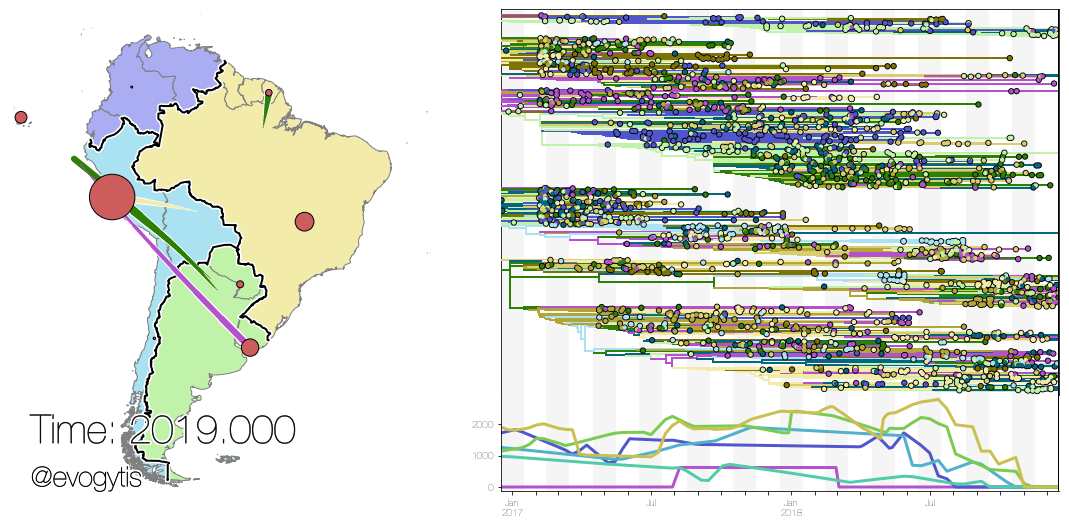

In [14]:
t0 = time.time() ## time how long animation takes

figWidth=10 ## map figure width
dpi=60 ## dots per inch for each .png (90 used in the final version)
every=6 ## put months labels every number of months

start='2017-01-01' ## start date of animation
end='2019-01-01' ## end date of animation

animation_grid=list(np.linspace(bt.decimalDate(start),bt.decimalDate('2018-01-01'),40)) ## few frames from 2011 to 2015
animation_grid+=list(np.linspace(bt.decimalDate('2018-01-01'),bt.decimalDate('2018-06-01'),40)) ## many frames from 2015 to 2016
animation_grid+=list(np.linspace(bt.decimalDate('2018-06-01'),bt.decimalDate(end),20)) ## medium frames from 2016 to 2018

tipSize=20 ## size of tip circles in tree
branchWidth=2 ## line width of tree branches

animation_duration=60.0 ## seconds

lims=[]
for i in range(2): ## iterate over x coordinates and y coordinates
    m=min([min([p.xy[:,i].min() for p in polygons[loc]]) for loc in popCentres.keys()]) ## get minimum coordinates
    M=max([max([p.xy[:,i].max() for p in polygons[loc]]) for loc in popCentres.keys()]) ## get maximum coordinates
    
    lims.append([m,M]) ## identify extremes of map based on edges of polygons
    
map_width,map_height=[int(abs(np.diff(l))) for l in lims] ## width and height of figure is difference in x and y limits
ratio=map_width/float(map_height) ## aspect ratio of map
xlims,ylims=lims
edges=0.01 ## fraction of space to give
xlims=[xlims[0]-map_width*edges,xlims[1]+map_width*edges] ## x axis limits for map
ylims=[ylims[0]-map_height*edges,ylims[1]+map_height*edges] ## y axis limits for map

print 'Start of animation: %.2f\nEnd: %.2f'%(min(animation_grid),max(animation_grid))

print len([x for x in bt_tree.Objects if x.traits.has_key(locTrait)==False])

print 'Number of frames to animate: %d'%(len(animation_grid))  
            
global travelers ## the animation will need to have information to traveling lineages
travelers=[x for x in bt_tree.Objects if x!=bt_tree.root and x.traits[locTrait]!=x.parent.traits[locTrait]] ## find lineages that have travelled - they're what's going to be animated
print '\nNumber of travelling lineages: %d (%.3f%% of all lineages)'%(len(travelers),len(travelers)/float(len(bt_tree.Objects))*100)

plt.figure(figsize=(figWidth*2,figWidth*ratio),facecolor='w') ## start figure

gs = gridspec.GridSpec(2, 2,width_ratios=[map_width,map_width],height_ratios=[4,1],wspace=0.0,hspace=0.0) ## using gridspec to set up several plots
ax1 = plt.subplot(gs[0:,0]) ## ax1 is map
ax2 = plt.subplot(gs[0, 1]) ## ax2 is tree
ax3 = plt.subplot(gs[1, 1]) ## ax3 is tertiary data

for loc in popCentres.keys():
    circle=plt.Circle(popCentres[loc],radius=0,label='%s_circle'%(loc),facecolor='indianred',edgecolor='k',lw=1,zorder=100) ## circle that tracks the number of lineages at location with radius 0 to begin with
    ax1.add_patch(circle) ## add circle to plot

for loc in polygons.keys(): ## iterate over locations, plot the initial setup
    poly=PatchCollection(polygons[loc],facecolor='w',edgecolor='grey',lw=1,label='%s_polygon'%(loc),zorder=95) ## location polygon
    ax1.add_collection(poly) ## add location polygon to plot

for stretch in international_border: ## plot international border
    xs,ys=zip(*stretch)
    ax1.plot(xs,ys,color='k',zorder=97,label='border_bg',lw=2)
    ax1.plot(xs,ys,color='w',zorder=96,label='border',lw=5)

ax1.spines['top'].set_visible(False) ## remove borders and axis labels
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(size=0) ## no ticks
ax1.set_xticklabels([]) ## no tick labels
ax1.set_yticklabels([])
ax1.set_aspect(1) ## aspect ratio == 1
ax1.set_ylim(ylims) ## set plot limits
ax1.set_xlim(xlims)

xtimeline=calendarTimeline(start,end,'%Y-%m-%d','%Y-%m-%d') ## create timeline from start to end of animation delimited with months
xpos=[bt.decimalDate(b) for b in xtimeline] ## convert calendar dates to decimal time
xlabels=[(bt.convertDate(b,'%Y-%m-%d','%b\n%Y') if '-01-' in b else bt.convertDate(b,'%Y-%m-%d','%b')) if (int(b.split('-')[1])+every-1)%every==0 else '' for b in xtimeline] ## month or year-month (if January) tick labels every given number of months

################
## Secondary plot begins - tertiary data
################
try:
    for i,group in enumerate(sorted_group): ## iterate through locations
        greyColour=mpl.cm.Greys ## get cmap
        c=group_colours[group](0.5) ## fixed colour
        locs=[loc for loc in aggregation.keys() if aggregation[loc]==group] ## get locations present in group
        animation_data=[sum([polygon_data[loc](day) for loc in locs if np.isnan(polygon_data[loc](day))==False]) for day in animation_grid] ## get sum of polygon data for each high order group, at every frame
        
        grey_colour=greyColour((i+1)/float(len(sorted_group)+2)) ## custom grey colour

        ax3.plot(animation_grid,animation_data,lw=3.3,color=grey_colour,zorder=2,label='BW') ## plot tertiary data for group in grey
        ax3.plot(animation_grid,animation_data,lw=3,color=c,zorder=1,label='Colour') ## plot tertiary data for group in colour, but underneath grey lines

    ax3.axvline(xpos[0],color='k',lw=3,label='time',zorder=100) ## add time arrow to indicate current time

    ax3.set_xticks([x+1/24.0 for x in xpos]) ## add ticks, tick labels and month markers
    ax3.set_xticklabels(xlabels) ## set x axis tick labels
    [ax3.axvspan(xpos[x],xpos[x]+1/12.,facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xpos),2)] ## add grey vertical bars for x axis

    ax3.xaxis.tick_bottom() ## make tertiary data plot pretty
    ax3.yaxis.tick_left()
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    
    ax3.set_xlim(min(xpos),max(xpos)) ## set plot x axis limits
except NameError:
    pass

################
## Secondary plot ends - tertiary data
################


################
## Tertiary plot begins - TREE
################

####
## UNCOMMENT if you'd like the tree to be plotted in grey initially and get coloured over time
####
# # iterate over objects in tree
# for k in bt_tree.Objects:
#     loc=k.traits[locTrait] ## get branch location
#     group=aggregation[loc]
#     cmap=group_colours[group] ## get colour map
#     c=cmap(normalised_coordinates[loc]) ## fixed colour for location
    
#     mask_cmap=mpl.cm.Greys ## colour map that goes on top of lines
#     grey_colour=mask_cmap((sorted_group.index(group)+1)/float(len(sorted_group)+2)) ## get colour based on index of location in list, avoiding white colour
    
#     y=k.y
#     yp=k.parent.y
    
#     x=k.absoluteTime
#     xp=k.parent.absoluteTime
    
#     if k.branchType=='leaf':
#         ax2.scatter(x,y,s=tipSize,facecolor=grey_colour,edgecolor='none',zorder=102,label='LeafBW_%s'%(k.index)) ## plot black and white tip circle on top
#         ax2.scatter(x,y,s=tipSize,facecolor=c,edgecolor='none',zorder=101,label='LeafColour_%s'%(k.index)) ## plot colour tip circle underneath black and white tip circle
#         ax2.scatter(x,y,s=tipSize*2,facecolor='k',edgecolor='none',zorder=100,label='Colour') ## black outline underneath every tip
        
#     elif k.branchType=='node':
#         yl=k.children[0].y
#         yr=k.children[-1].y
        
#         if xp==0.0:
#             xp=x

#         ax2.plot([x,x],[yl,yr],color=grey_colour,lw=branchWidth,zorder=99,label='NodeHbarBW_%s'%(k.index))
#         ax2.plot([x,x],[yl,yr],color=c,lw=branchWidth,zorder=98,label='NodeHbarColour_%s'%(k.index))
        
#     ax2.plot([xp,x],[y,y],color=grey_colour,lw=branchWidth,zorder=99,label='BranchBW_%s'%(k.index)) ## plot black and white branch on top
#     ax2.plot([xp,x],[y,y],color=c,lw=branchWidth,zorder=98,label='BranchColour_%s'%(k.index)) ## plot colour branch underneath black and white branch (note the zorder attribute)
    
####
## UNCOMMENT if you'd like the tree to be plotted in grey initially and get coloured over time
####

ax2.axvline(xpos[0],color='k',lw=3,label='time',zorder=200) ## add time arrow to indicate current time

ax2.set_xticks([x+1/24.0 for x in xpos]) ## add ticks, tick labels and month markers
ax2.set_xticklabels(xlabels) ## set x axis labels
[ax2.axvspan(xpos[x],xpos[x]+1/12.,facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xpos),2)] ## set grey vertical bars for x axis

ax2.xaxis.tick_bottom() ## make tree plot pretty
ax2.yaxis.tick_left()
[ax2.spines[loc] for loc in ax2.spines]

ax2.tick_params(axis='x',size=0) ## no ticks
ax2.tick_params(axis='y',size=0)
ax2.set_xticklabels([]) ## no tick labels
ax2.set_yticklabels([])

ax2.set_xlim(min(xpos),max(xpos)) ## axis limits
ax2.set_ylim(-bt_tree.ySpan*0.01,bt_tree.ySpan*1.01)
################
## Tertiary plot ends - TREE
################


def animate(frame):
    #### Primary plotting (map)
    ax1.lines=[line for line in ax1.lines if 'border' in line.get_label()] ## reset lines (except borders) and texts in the plot
    ax1.texts=[] ## remove all text from plot
    
    if len(animation_grid)-1==frame: ## if at last frame
        next_time=animation_grid[frame] ## current frame is next frame
    else:
        next_time=animation_grid[frame+1] ## next frame
        
    current_time=animation_grid[frame]
    
    effects=[path_effects.Stroke(linewidth=4, foreground='white'),
                 path_effects.Stroke(linewidth=0.5, foreground='k')] ## black text, white outline

    ax1.text(0.05,0.1,'Time: %.3f'%(current_time),size=40,transform=ax1.transAxes,zorder=1000,path_effects=effects) ## add text to indicate current time point
    ax1.text(0.05,0.0,'@evogytis',size=28,ha='left',va='bottom',transform=ax1.transAxes,zorder=1000,path_effects=effects) ## "watermark"
    
    exists=[k for k in bt_tree.Objects if k.parent!=bt_tree.root and k.parent.absoluteTime<=current_time<=k.absoluteTime] ## identify lineages that exist at current timeslice

    lineage_locations=[c.traits[locTrait] for c in exists if c.traits[locTrait]!='Not Available'] ## identify locations where lineages are present
    presence=set(lineage_locations) ## all locations where lineages currently are in the tree

    circle=[c.set_radius(0) for c in ax1.patches if '_circle' in c.get_label()] ## reset circle sizes

    for region in presence: ## iterate through every region where a lineage exists
        circle=[c for c in ax1.patches if c.get_label()=='%s_circle'%(region)][0] ## fetch circle of location
        circle.set_radius(circle_function[region](current_time)) ## adjust radius

    for k in travelers: ## iterate through travelling lineages
        transition=k.parent.absoluteTime+k.length*transition_point ## fixed point at which lineage reaches destination
        
        if current_time-depth<transition<current_time+depth: ## make sure transition is within period of animation
            frac=1-(transition-current_time)/float(depth) ## frac will go from 0.0 to 2.0
            ori=k.parent.traits[locTrait] ## fetch locations
            des=k.traits[locTrait]  
            
            if aggregation[ori]!=aggregation[des]:
                fc=group_colours[aggregation[ori]](normalised_coordinates[ori])
            else:
                fc='k' ## colour line black unless it's travelling between countries

            lineage_tail=departure_condition(frac) ## Bezier line begins at half a fraction along the path
            lineage_head=frac
            
            lineage_tail,lineage_head=np.clip([lineage_tail,lineage_head],0.0,1.0) ## clip fractions to be within interval (0.0,1.0)
            
            eval_Bezier=np.linspace(lineage_tail,lineage_head,smooth)
            line=migration_function[ori][des](eval_Bezier)
            xs,ys=line
            if lineage_head>0.0 and lineage_tail<1.0: ## only plot if line begins before destination
                for q in range(len(xs)-1): ## iterate through Bezier line segments with fading alpha and reducing width
                    x1,y1=xs[q],ys[q] ## get coordinates for current segment's start
                    x2,y2=xs[q+1],ys[q+1] ## get coordinates for current segment's end

                    segL=(q+1)/float(len(xs)) ## fraction along length of Bezier line
                    
                    ax1.plot([x1,x2],[y1,y2],lw=7*segL,alpha=1,color=fc,zorder=99,solid_capstyle='round') ## plot actual lineage
                    ax1.plot([x1,x2],[y1,y2],lw=10*segL,alpha=1,color='w',zorder=98,solid_capstyle='round') ## plot underlying white background to help lineages stand out

    for i,loc in enumerate(polygons.keys()): ## iterate over locations
        group=aggregation[loc]
        cmap=group_colours[group] ## get cmap
        frac=polygon_data[loc](current_time)/polygon_max[group] ## get interpolated tertiary data as fraction of maximum
        c=cmap(frac) ## get colour
        loc_polygons=[p for p in ax1.collections if p.get_label()=='%s_polygon'%(loc)] ## get location polygon
        for polygon in loc_polygons: ## for each component polygon
            polygon.set_facecolor(c) ## change the colour of locations based on tertiary value
    
    update=10 ## update progress bar every X frames
    
    #### Secondary plotting (tree)
    Ls2=[x for x in ax2.lines if 'Colour' not in str(x.get_label())] ## fetch all lines in plot
    partials=[x for x in ax2.lines if 'partial' in str(x.get_label())] ## fetch all tree branches in progress
    finished_lines=[x for x in ax2.lines if 'finished' in str(x.get_label())] ## fetch all tree branches that are finished
    finished_points=[x for x in ax2.collections if 'finished' in str(x.get_label())] ## fetch all tip circles that are finished
    
    finished_labels=[str(x.get_label()) for x in finished_lines]+[str(x.get_label()) for x in finished_points] ## combine everything that's finished (branches + tip circles)
    partial_labels=[str(x.get_label()) for x in partials] ## partially plotted branches
    
    if frame>0 and frame%update==0: ## progress bar
        clear_output()
        timeElapsed=(time.time() - t0)/60.0
        progress=int((frame*(50/float(len(animation_grid)))))
        percentage=frame/float(len(animation_grid))*100
        rate=timeElapsed/float(frame)
        ETA=rate*(len(animation_grid)-frame)
        sys.stdout.write("[%-50s] %6.2f%%  frame: %5d %10s  time: %5.2f min  ETA: %5.2f min (%6.5f s/operation) %s %s %s" % ('='*progress,percentage,frame,animation_grid[frame],timeElapsed,ETA,rate,len(partials),len(finished_lines),len(finished_points)))
        sys.stdout.flush()

    ####
    ## COMMENT this bit out if you don't want the tree to appear out of the time arrow
    ####
    for ap in bt_tree.Objects: ## iterate over branches
        idx='%s'%(ap.index) ## get unique id of branch
        xp=ap.parent.absoluteTime ## get parent's time

        x=ap.absoluteTime ## get branch's time
        y=ap.y ## get branch's y coordinate

        location=ap.traits[locTrait] ## get branch's location
        group=aggregation[location] ## get location's group
        cmap=group_colours[group] ## get group colour map
        c=cmap(normalised_coordinates[location]) ## get colour
        if xp<=current_time<x: ## branch is intersected by time arrow
            if 'partial_%s'%(idx) in partial_labels: ## if branch was partially drawn before
                l=[w for w in partials if 'partial_%s'%(idx)==str(w.get_label())][-1] ## get branch line
                l.set_data([xp,current_time],[y,y]) ## adjust its end coordinate to be time arrow
            else: ## branch is intersected, but not drawn before
                ax2.plot([xp,current_time],[y,y],lw=branchWidth,color=c,zorder=99,label='partial_%s'%(ap.index)) ## draw branch ending at time arrow, label as partially drawn
                
        if x<=current_time: ## time arrow passed branch - add it to finished class
            if 'partial_%s'%(idx) in partial_labels: ## if branch has been partially drawn before
                l=[w for w in partials if 'partial_%s'%(idx)==str(w.get_label())][-1] ## get branch
                l.set_data([xp,x],[y,y]) ## set end coordinate to be actual end coordinate
                l.set_label('finished_%s'%(idx)) ## set its label to finished
                
            if 'finished_%s'%(idx) not in finished_labels: ## branch has not been drawn before at all
                ax2.plot([xp,x],[y,y],lw=branchWidth,color=c,zorder=99,label='finished_%s'%(ap.index)) ## draw branch, add to finished class
                
            if 'partial_%s'%(idx) in partial_labels or 'finished_%s'%(idx) not in finished_labels: 
                if ap.branchType=='leaf': ## if leaf
                    ax2.scatter(x,y,s=tipSize,facecolor=c,edgecolor='none',zorder=102,label='finished_%s'%(ap.index)) ## add tip circle
                    ax2.scatter(x,y,s=tipSize*2,facecolor='k',edgecolor='none',zorder=101,label='finished_%s'%(ap.index)) ## add tip circle outline underneath
                elif ap.branchType=='node': ## if node
                    yl=ap.children[0].y ## get y coordinates of first and last child
                    yr=ap.children[-1].y
                    ax2.plot([x,x],[yl,yr],lw=branchWidth,color=c,zorder=99,label='finished_%s'%(ap.index)) ## plot vertical bar for node
    ####
    ## COMMENT this bit out if you don't want the tree to appear out of the time arrow
    ####
                
    for l in Ls2: ## iterate over lines in tree
        if 'time' in l.get_label(): ## if line is time arrow
            l.set_data([current_time,current_time],[0,1]) ## adjust time arrow
            
#         #### 
#         ## UNCOMMENT this bit if you'd like lineages to be coloured over time
#         ####
#         else:
#             d_xs,d_ys=l.get_data() ## fetch all line data
#             start,end=d_xs ## extract x coordinates
#             if end<current_time: ## if time arrow passed end point of line
#                 ax2.lines.remove(l) ## delete line
#             elif start<current_time: ## if time arrow passed start of line
#                 l.set_data([current_time,end],d_ys) ## adjust start of line to be time's arrow
    
#     Ps2=[x for x in ax2.collections if 'Colour' not in str(x.get_label())] ## iterate over collections (scatter points) in tree plot
    
#     for p in Ps2:
#         coords=p.get_offsets() ## fetch coordinates
#         if len(coords)==1: ## only alter points with 1 coordinate
#             if coords[0][0]<=float(current_time): ## time's arrow is after x coordinate
#                 ax2.collections.remove(p) ## remove black and white point if time arrow has passed
        #### 
        ## UNCOMMENT this bit if you'd like lineages to be coloured over time
        ####
    
    ### Tertiary plotting (tertiary data)
    try:
        Ls3=[x for x in ax3.lines if 'Colour' not in str(x.get_label())] ## fetch all the lines with labels in cases plot
        for l in Ls3:
            if 'time' in l.get_label(): ## if line is time arrow
                l.set_data([current_time,current_time],[0,1]) ## adjust time arrow
            else: ## not time arrow - tertiary plot lines
                d=l.get_xydata() ## fetch all line data

                for e in range(len(d)-1): ## iterate over points
                    x_now=d[:,0][e] ## get coordinates of current positions
                    y_now=d[:,1][e]

                    x_nex=d[:,0][e+1] ## cordinates of next position
                    y_nex=d[:,1][e+1]
                    if x_now<current_time: ## time arrow passed x coordinate
                        d[:,0][e]=current_time # adjust x coordinate so it's sitting on top of time arrow
                        d[:,1][e]=y_now+((y_nex-y_now)/(x_nex-x_now))*(current_time-x_now) ## interpolate where new y position is
                l.set_data(d.transpose()) ## set new data
    except NameError:
        pass

for frame in range(len(animation_grid)): ## iterate through each frame
    animate(frame) ## animate will modify the map, tree and cases
    plt.savefig('/Users/evogytis/Documents/BLAB_baltic/ani_frame_%05d.png'%(frame), format='png',bbox_inches='tight',dpi=dpi) ## save individual frames for stitching up using 3rd party software (e.g. FFMpeg)

print '\n\nDONE!'

print '\nTime taken: %.2f minutes'%((time.time() - t0)/60.0)

print 'Suggested frame rate for an animation lasting %s seconds using %s frames: %s'%(animation_duration,len(animation_grid),int(len(animation_grid)/animation_duration)) ## frame rate
plt.show()

## Rendering animation
----------
Once you have the individual frames saved to file we'll use `FFmpeg` on the command line to render the animation. Needless to say you need `FFmpeg` installed and available on the command line. You should provide an integer of your choice for the `-framerate` parameter to control how fast frames are replayed. Ideally should be >25.

In [15]:
%%bash

frames=/Users/evogytis/Documents/BLAB_baltic/

cd  $frames; rm baltic_animation.HD.264.mp4; ffmpeg -framerate 4 -start_number 0 -i ani_frame_%05d.png -pix_fmt yuv420p -b:a 64k -vf scale="2160:trunc(ow/a/2)*2" baltic_animation.HD.264.mp4


ffmpeg version 4.1 Copyright (c) 2000-2018 the FFmpeg developers
  built with clang version 4.0.1 (tags/RELEASE_401/final)
  configuration: --prefix=/miniconda2 --cc=x86_64-apple-darwin13.4.0-clang --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib
  libavutil      56. 22.100 / 56. 22.100
  libavcodec     58. 35.100 / 58. 35.100
  libavformat    58. 20.100 / 58. 20.100
  libavdevice    58.  5.100 / 58.  5.100
  libavfilter     7. 40.101 /  7. 40.101
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  3.100 /  5.  3.100
  libswresample   3.  3.100 /  3.  3.100
  libpostproc    55.  3.100 / 55.  3.100
Input #0, image2, from 'ani_frame_%05d.png':
  Duration: 00:00:25.00, start: 0.000000, bitrate: N/A
    Stream #0:0: Video: png, rgba(pc), 892x441 [SAR 2362:2362 DAR 892:44